In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Reference: https://github.com/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent assistant, we've been introducing a few LangGraph controllability topics.

We just covered parallelization and sub-graphs.

In [2]:
%%capture --no-stderr
%pip install -U -q langchain_openai langgraph

In [3]:

import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


In [4]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY:  ········


In [5]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

In [6]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

In [7]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

In [8]:
from langgraph.types import Send
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

In [9]:
class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

In [10]:
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

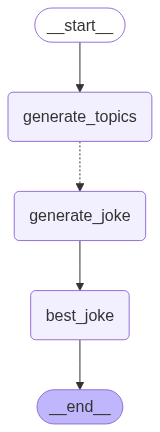

In [11]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [12]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['Animal Behavior and Communication', 'Conservation and Endangered Species', 'Animal Physiology and Adaptations']}}
{'generate_joke': {'jokes': ['Why did the parrot bring a ladder to the comedy club?\n\nBecause it wanted to reach the "punchline" in its jokes!']}}
{'generate_joke': {'jokes': ['Why did the endangered species start a band?\n\nBecause they wanted to make some noise before they went extinct!']}}
{'generate_joke': {'jokes': ['Why did the chameleon bring a ladder to the party?\n\nBecause it heard the drinks were on the house, and it wanted to adapt to the situation!']}}
{'best_joke': {'best_selected_joke': 'Why did the parrot bring a ladder to the comedy club?\n\nBecause it wanted to reach the "punchline" in its jokes!'}}


In [13]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "garden"}):
    print(s)

{'generate_topics': {'subjects': ['Sustainable Gardening Practices', 'Urban Gardening and Vertical Farming', 'Native Plant Landscaping']}}
{'generate_joke': {'jokes': ['Why did the tomato turn red in the sustainable garden?\n\nBecause it saw the salad dressing and realized it was compostable!']}}
{'generate_joke': {'jokes': ['Why did the tomato join the vertical farming club?\n\nBecause it wanted to rise to the top and squash the competition!']}}
{'generate_joke': {'jokes': ['Why did the gardener bring a ladder to the native plant garden?\n\nBecause they heard the plants were "rooting" for a higher ground! 🌱😄']}}
{'best_joke': {'best_selected_joke': 'Why did the tomato join the vertical farming club?\n\nBecause it wanted to rise to the top and squash the competition!'}}


In [15]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "knock-knock"}):
    print(s)

{'generate_topics': {'subjects': ['History and Origins of Knock-Knock Jokes', 'Cultural Variations in Knock-Knock Jokes', 'Psychological Impact of Humor: Why Knock-Knock Jokes Make Us Laugh']}}
{'generate_joke': {'jokes': ["**Knock, knock.**  \n**Who's there?**  \n**Hist.**  \n**Hist who?**  \n**Hist-orically speaking, the origins of knock-knock jokes are a mystery, but they sure have a door-ably long history!**"]}}
{'generate_joke': {'jokes': ['**Knock, knock!**\n\n**Who\'s there?**\n\n**Cultural.**\n\n**Cultural who?**\n\n**Cultural differences! In France, they just say "Bonjour!" and let themselves in!** 😂']}}
{'generate_joke': {'jokes': ["**Knock, knock.**  \n**Who's there?**  \n**Laughter.**  \n**Laughter who?**  \n**Laughter is the best medicine, but only if you don't mind the side effects of giggles and snorts!**\n\nWhy do knock-knock jokes make us laugh? Because they knock on the door of our minds, and when we open up, we find a little surprise waiting to tickle our funny bone!

In [19]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "Kids"}):
    print(s)

{'generate_topics': {'subjects': ['Child Development', 'Educational Activities for Kids', 'Health and Nutrition for Children']}}
{'generate_joke': {'jokes': ['Why did the toddler bring a ladder to the playground?\n\nBecause they heard they were going through a "growth spurt" and wanted to be prepared!']}}
{'generate_joke': {'jokes': ['Why did the broccoli break up with the carrot?\n\nBecause it couldn\'t "kale" with its "peas" of mind!']}}
{'generate_joke': {'jokes': ['Why did the math book look sad during the educational activity?\n\nBecause it had too many problems!']}}
{'best_joke': {'best_selected_joke': 'Why did the math book look sad during the educational activity?\n\nBecause it had too many problems!'}}
